# Attention Pooling by Similarity

In this notebook we will be using the primary components of the attention mechanism in a classical setting involving regression and classification via kernel density estimation. This will serve simply as a way to solidify the background knowledge on the fundations of the attention mechanisms. 

(To be added the mathematical notation)

In [2]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()

## Kernels and Data

All the kernels defined in this section are _translation and rotation invariant_, that is, if we shift and rotate __k__ and __q__ in the same manner, the value of alpha remains unchanged. 

Picking scalar arguments _k_, _q_ are Reals and _k = 0_ as the origin. 

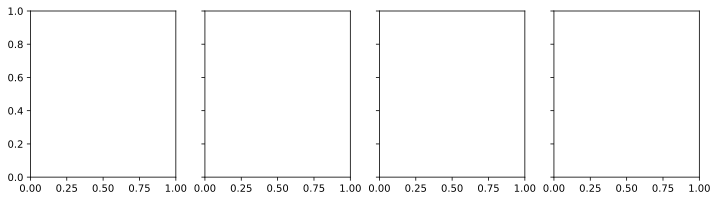

In [4]:
fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

# Define some kernels
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

In [9]:
kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

In [10]:
def f(x):
    return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

## Attention Pooling via Nadaraya-Watson Regression

In [11]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)
    # Normalization over keys for each query
    attention_w = k / k.sum(0)
    y_hat = y_train@attention_w
    return y_hat, attention_w

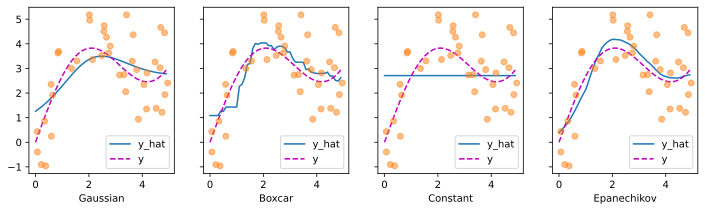

In [12]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)

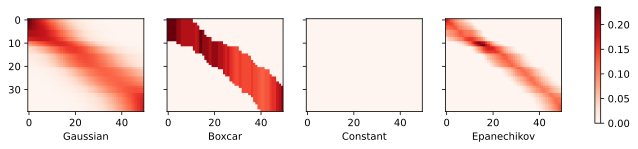

In [13]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

## Adapting Attention Pooling

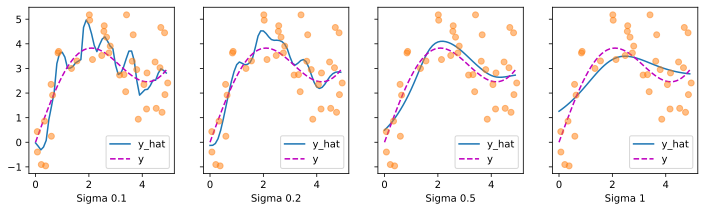

In [14]:
sigmas = (0.1, 0.2, 0.5, 1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))

kernels = [gaussian_with_width(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)

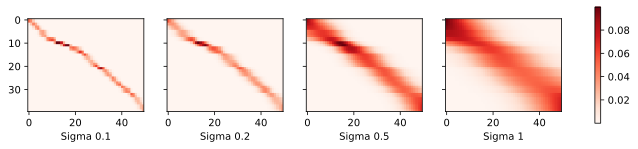

In [15]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)